
## MED 5

# Metody ograniczenia wariancji modelu

Poszukując modelu regresji, czy klasyfikacji staramy się, by powstały estymator posiadał porządane statystycznie cechy: był zgodny, nieobciążony i najbardziej efektywny. W rzeczywistości trudno jest pogodzić dwie ostatnie własności. Przez brak obciążenia (ang.bias) rozumie się bowiem jak najlepsze dopasowanie do danych uczących. Przez największą efektywność rozumie się zwykle jak najmniejszy błąd estymacji dla zbioru testowego (każdego innego niż uczący) - najmniejszą wariancję modelu. Dla rzeczywistych zbiorów danych, na ogół, im mniejsze jest obciążenie, tym jest większa wariancja modelu i odwrotnie. Z uwagi jednak na fakt, iż celem dla którego powstaje model estymatora, jest jak najskuteczniejsze jego działanie dla nowych danych (innych niż uczące), przy tworzeniu modelu stosuje się metody, które kosztem zwiększenia obciążenia, zmniejszają wariancję modelu. W praktyce jest to osiągane przez poszukiwanie, w procesie uczenia,  modelu na tyle prostego by właściwie odwzorowywać trend, niekoniecznie idealnie dopasowującego się do danych zbioru uczącego.  

Zwiększając liczbę cech modelu oraz tworząc nowe zmienne opisujące zwiększa się zwykle jego wariancja. Widać to wyraźnie w przypadku zastosowania regresji wielomianowej. Zwiększanie stopnia wielomianu opisującego trend naszych danych zwiększane zostają współczynniki stojące przy kolejnych potęgach, co pozwala na dokładne dopasowanie modelu do danych uczących, jednak kosztem zwiększenia jego wariancji. Mimo iż obciążenie modelu z punktu widzenia danych uczących spada do zera, to tracimy jego zdolności uogólnienia (błąd estymacji wartości na podstawie zbioru testowego rośnie), co oznacza przeuczenie/nadmierne dopasowanie (ang. overfitting) naszego modelu.

Sposobem na redukcję stopnia przeuczenia/nadmiernego dopasowania modelu, a zatem ograniczenia jego wariancji, w przypadku regresji wielomianowej, są techniki regularyzacji. Generalnie mamy dwie możliwości działania:

1. Redukujemy wpływ cech nieznaczących na model tj. pozostawiamy wszystkie cechy ale w modelu realny wpływ na wyjście mają jedynie cechy znaczące - działa jeśli mamy dużo cech, z których każda skorelowana jest z wyjściem (regularyzacja Tichonowa, regresja grzbietowa - ang. ridge regression).
       
2. Redukujemy liczbę cech na jeden z trzech sposobów:

    a) selekcja manualna - używamy ważniejszych cech (w przypadku unormowanych wartości atrybutów opisujących będą to cechy, przy których wartość modułu współczynnika jest najwyższa)    
    
    b) używamy algorytmu do wyboru cech modelu (metoda zachłanna - analizujemy które cechy najlepiej minimalizują sumę kwadratu błędów)
    
    c) używamy metody regularyzacji eliminującej zbędne cechy (metoda lasso). 

Regresja grzebietowa i Lasso to efektywne techniki zwykle stosowane do tworzenia oszczędnych modeli w obecności „dużej” liczby funkcji. Tutaj „duże” może zwykle oznaczać jedną z dwóch rzeczy:

1. Wystarczająco duży, aby zwiększyć tendencję modelu do nadmiernego dopasowania (tak niskie, jak 10 zmiennych może powodować nadmierne dopasowanie)
    
2. Wystarczająco duży, aby powodować wyzwania obliczeniowe. W przypadku nowoczesnych systemów taka sytuacja może wystąpić w przypadku milionów lub miliardów cech.

Chociaż metoda grzebietowa i Lasso mogą wydawać się bardzo do siebie  podobne, dzięki specyficznym własnościom ich praktyczne zastosowania różnią się znacznie. Działają one poprzez karanie wielkości współczynników cech oraz minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami. Kluczowa różnica polega na sposobie przypisywania kary do współczynników:

* Regresja grzbietowa (ridge regression, regularyzacja Tichonowa):
        Dokonuje normalizacji L2, tj. Dodaje karę równą kwadratowi wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma kwadratów współczynników)
* Regresja lasso:
        Dokonuje normalizacji L1, tj. Dodaje karę równoważną wartości bezwzględnej wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma wartości bezwzględnych współczynników)

„LS Obj” odnosi się do „celu najmniejszych kwadratów”, tj. Celu regresji liniowej bez regularyzacji.

**Celem tego laboratorium jest zapoznanie się z działaniem metod regularyzacji i dobru cech modelu**.


Materiały pomocnicze, lekkie (wideo) wprowadzenia do :

* [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Metody lasso](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [i połączenie obu (elastic net)](https://www.youtube.com/watch?v=1dKRdX9bfIo)

Na początek - wczytanie bibliotek oraz wygenerowanie zbioru danych:

In [2]:
# Wczytaj bilbioteki podstawowe
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [3]:
# Wczytaj biblioteki potrzebne do zajęć
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
# %% ignorowanie warming
import warnings
warnings.filterwarnings("ignore")

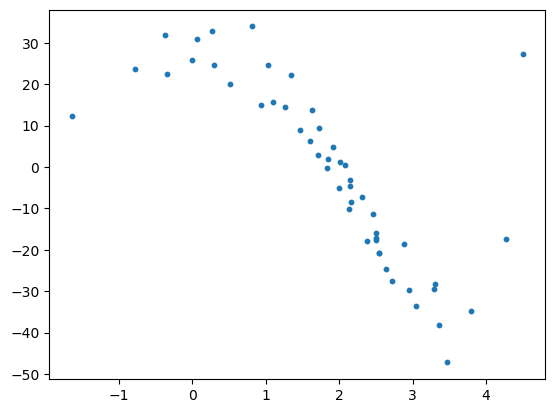

In [4]:
np.random.seed(5)
x = 2 - 3 * np.random.normal(0, 0.5, 50)
y = 30 + x - 5 * (x ** 2) - 2 * (x ** 3)+ 0.15 * (x ** 5)  + np.random.normal(-3, 5, 50)
plt.scatter(x,y, s=10)
plt.show()

### Zadanie 1 - regresja grzbietowa (ridge regression)

Zadanie polega na znalezieniu wielomianu $\hat{f}(x)$ postaci:

$$\hat{f}(x)=\omega_0+\omega_1 x^1+\omega_2x^2+ … +\omega_n x^n,$$

który mimo wysokiej złożoności modelu nie powoduje nadmiernego dopasowania do danych uczących poprzez zastosowanie regularyzacji L2.

Chcemy by nasza funkcja kosztu C($\omega$) miała postać:

$$C_{ridge}(\omega)=\sum_{i=0}^{k-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^n{\omega^2_j},$$

gdzie $i$ oznacza numer obserwacji, a $j$ kolejność współczynnika.

Wtedy rozwiązanie naszego równania wyzaczającego współczynniki wygląda w następujący sposób:

$$ \omega=\left(X^T X + \lambda \begin{bmatrix}
0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & \ddots & 0\\ 
0 & 0 & 0  & 1 \\ 
\end{bmatrix}\right) ^{-1} X^Ty $$

**Należy pamiętać, że wyrazu wolnego nie poddajemy regularyzacji !**

A zatem - do dzieła!!!

W ramach pierwszej części zadania należy napisać funkcję wyznaczającą współczynniki $\omega$ wielomianowej funkcji regresji zgodnie z powyższym wzorem.

In [5]:
def create_matrix(x,stop):
    X = np.ones((len(x),stop +1))
    X[:,1] = x 
    for i in range(stop-1):
        X[:,i+1] = x**(i+1)
    return X

In [6]:
# Napisz funkcję dopasowującą model regresji wielomianowej z regularyzacją L2 
# (wykorzystując rozwiązanie równania normalnego)
def regresja_L2(X, y, lamb, stopien_wielomianu):
    # X = create_matrix(X,stopien_wielomianu)
    m = np.eye(stopien_wielomianu+1)
    m[0] = 0
    
    w = np.dot(np.linalg.pinv(np.dot(X.T,X) + lamb * m), np.dot(X.T,y))
    return w


Poprawne (lub nie) działanie powyższej funkcji należy sprawdzić rysując jej wykres na wykresie punktowym zbioru danych

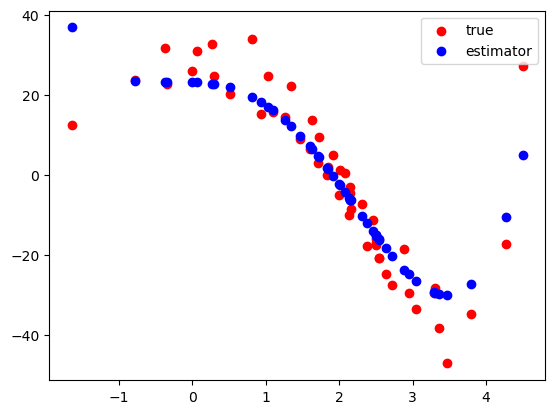

In [7]:
# Rysowanie wykresu 
X = create_matrix(x,5)
w = regresja_L2(X, y, 100, 5)

plt.scatter(x, y,c = 'red',)
plt.scatter(x, np.dot(X, w), c='blue')
plt.legend(['true','estimator'])
plt.show()

Podobnie jak wiele innych metod uczenia maszynowego, także i metoda regresji grzbietowej została zaimplementowana w jednym z pakietów języka Python. W kolejnym kroku nalezy znaleźć stosowną funkcję oraz porównać wyniki jej działania z własną funkcją.

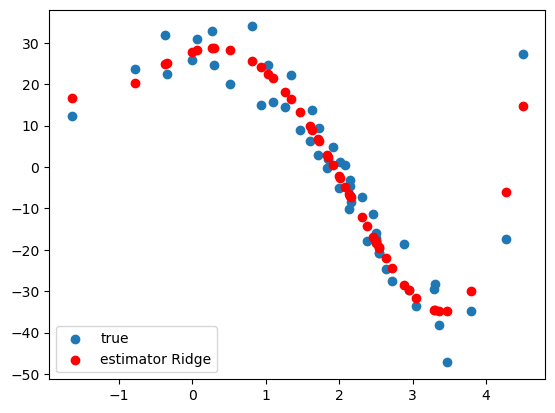

In [8]:
# miejsce na kod
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0,random_state=0,) 
model.fit(X,y)
predictions = model.predict(X)
plt.scatter(x, y)
plt.scatter(x, predictions, c='red')
plt.legend(['true','estimator Ridge'])
plt.show()


Widac, ze  zaimplementowana metoda ridge działa zdecydowanie lepiej na zbierze trenigowym niż tworzana przez mnie regresja grzbietowa.  

Celem wyznaczenia funkcji regresji na całym zbiorze, tak jak to miało miejsce powyżej, było praktyczne sprawdzenie jej działania. W przypadku, gdy uzyskany model estymatora miałby być zastosowany do estymacji wartości wyjściowej dla nieznanych wartości wejściowych (a zwykle tak to właśnie wygląda), oryginalny zbiór danych powinien zostac podzielony na zbiór uczący i testowy.

In [9]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
X = create_matrix(x,15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Do oceny modelu w procesie uczenia stosuje się często walidację krzyżową. W omawianym przypadku wyróżnia się dwa parametry metody - stopień wielomianu funkcji regresji oraz parametr $\lambda$. Zwykle pierwszy z nich jest ustalany a-priori, zaś drugi podlega weryfikacji poprzez wykonanie walidacji krzyżowej estymatorów dla różnych jego wartości. 

Korzystając z walidacji krzyżowej (5-krotny wybór zbioru) na zbiorze treningowym napisz funkcję, która dla wielomianu stopnia 15 narysuje wykres średniego błędu uczenia i średniego błędu walidacji, jak również wykres przedstawiający wartości współczynników modelu w funkcji zmiany parametru regularyzacji $\lambda=[0, 0.01, 0.02, 0.04, 0.08, \cdots, 10]$. Można przyjąć, że $\lambda_{a+1}=24\lambda_a$. Można skorzystać z funkcji [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) lub [Search_Grid_CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

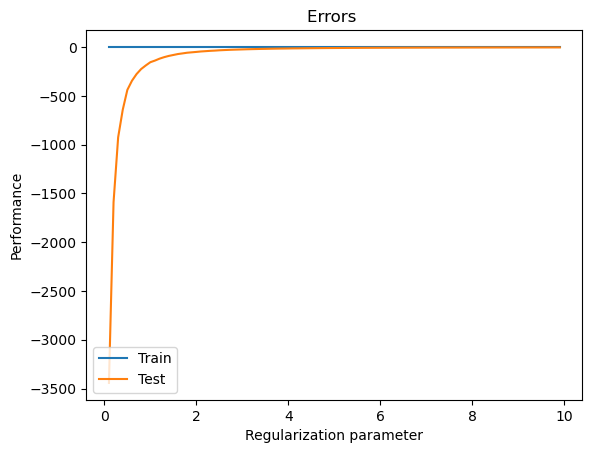

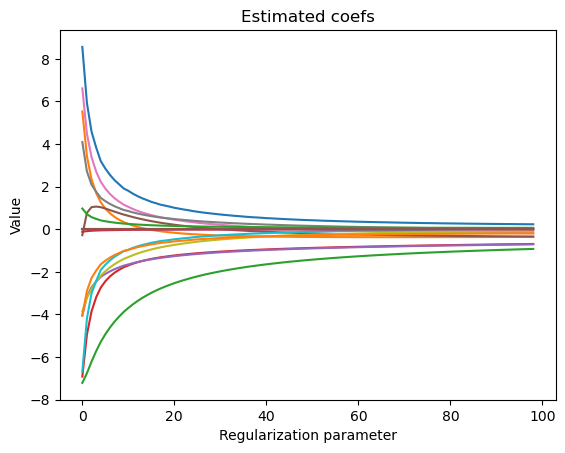

In [10]:
train_scores = []
test_scores = []
w_list = []
alphas = np.arange(0.1,10,0.1)
for alpha in alphas:
    clf = Ridge(alpha= alpha)
    scores = cross_validate(clf, X_train, y_train, cv=5,return_estimator = True) 
    # print(scores['test_score'])
    estymator  = scores['estimator'][np.argmax(scores['test_score'])]
    train_score = estymator.score(X_train,y_train)
    test_score = estymator.score(X_test,y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    w = estymator.coef_
    w_list.append(w)

# clf = Ridge(alpha=2)
# clf.fit(X_train,y_train)
# print(clf.coef_)

plt.title('Errors ')
plt.plot(alphas, train_scores, label="Train")
plt.plot(alphas, test_scores, label="Test")

plt.legend(loc="lower left")
# plt.ylim([0, 1.2])

plt.ylabel("Performance")
plt.xlabel("Regularization parameter")
# # Show estimated coef_ vs true coef
plt.show()
# plt.plot(coef, label="True coef")
plt.title("Estimated coefs")
plt.plot(w_list)
plt.ylabel("Value")
plt.xlabel("Regularization parameter")

# plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()





Config: {'alpha': 0.52}
1000


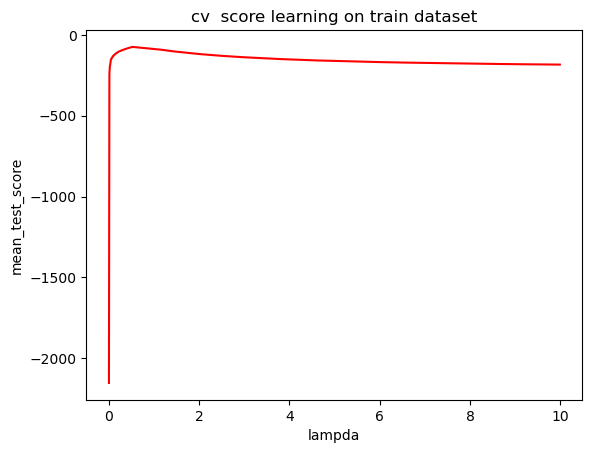

In [11]:
# Wykorzystując  GridSearchCV do lepszego obrazowania, zmiany współczynika lampda dla zbioru traingowego
#  
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold


# cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
model = Ridge() 
grid = dict()
grid['alpha'] = np.arange(0, 10, 0.01)
# define search
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)  

search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# scores = cross_validate(model,X_train,y_test)
# perform the search
results = search.fit(X_train, y_train)

print('Config: %s' % results.best_params_)
print(len(results.cv_results_['mean_test_score']))
plt.plot(grid['alpha'], results.cv_results_['mean_test_score'], c='red')
plt.xlabel('lampda')
plt.ylabel('mean_test_score')
plt.title('cv  score learning on train dataset')
plt.show()


**Pytania:**
1. Jak zmieniają się wartości współczynników ze zmianą współczynnika regularyzacji $\lambda$?
2. Która wartość współczynnika regularyzacji $\lambda$ jest najlepsza dla wybranego modelu?

1
Wraz z wzrostem $\lambda$, spólczyniki maleją bo ich znaczenie w funkcji  kosztu wrasta   $$C_{ridge}(\omega)=\sum_{i=0}^{k-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^n{\omega^2_j},$$)

In [12]:
# 2. Która wartość współczynnika regularyzacji $\lambda$ jest najlepsza dla wybranego modelu?

# Możemy to odczytać z wykresu wyżej, jednak istnieje już  gotowa funckja RidgeCV, która sama znajdzie odpowiedni współczynik  lampda 


from numpy import arange
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1) 
model = RidgeCV(alphas=arange(0, 10, 0.1), cv=cv, scoring='neg_mean_absolute_error',)

model.fit(X_train, y_train)

print('lambda: %f' % model.alpha_)


lambda: 0.500000


- Dobór, współczynika  lambda  mozemy dokonać, na podstawienie wyniku cv. 

- Cross validate, wykonujemy na zbiorze traingowy i na tej podstawie wybieramy odpowiednie współczyniki.

- Cross validate, nie sluszy do uczenia zbioru a jedynie do oceny parametrów.

Wyucz opracowany model (stopnia 15) dla wybranego współczynnik $\lambda$ (uczenie na całym zbiorze treningowym). Wyznacz $\mbox{RMSE}=\sqrt{\frac{1}{k}\sum_{i=1}^{k}\left(\hat{f}(x_i)−y_i\right)^2}$ (pierwiastek błędu średniokwadratowego) dla zbioru uczącego i testowego i porównaj z wynikiem otrzymanym dla modelu stopnia 5.  

In [13]:
# Miejsce na potrzebne funkcje

X = create_matrix(x,15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

w = regresja_L2(X_train, y_train, 0.5, 15)

train_root_of_mean_square_error_15_degree = np.sqrt(sum((y_train - np.dot(X_train, w))**2)) / len(X_train)   
test_root_of_mean_square_error_15_degree = np.sqrt(sum((y_test - np.dot(X_test, w))**2)) / len(X_test)   
print(f'train root_of_mean_square_error_15_degree:  {train_root_of_mean_square_error_15_degree}')
print(f'test root_of_mean_square_error_15_degree:  {test_root_of_mean_square_error_15_degree}')


X = create_matrix(x,5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

w = regresja_L2(X_train, y_train, 0.5, 5)

train_root_of_mean_square_error_5_degree = np.sqrt(sum((y_train - np.dot(X_train, w))**2)) / len(X_train)   
test_root_of_mean_square_error_5_degree = np.sqrt(sum((y_test - np.dot(X_test, w))**2)) / len(X_test)   
print(f'train root_of_mean_square_error_5_degree:  {train_root_of_mean_square_error_5_degree}')
print(f'test root_of_mean_square_error_5_degree:  {test_root_of_mean_square_error_5_degree}')


train root_of_mean_square_error_15_degree:  2.37178691110616
test root_of_mean_square_error_15_degree:  3.4168370684116693
train root_of_mean_square_error_5_degree:  0.8485657030565557
test root_of_mean_square_error_5_degree:  4.260483300435475


Jest to mały zbiór danych, wiec duże ma znaczenie podzial zbioru  (random_state). 

Dobrane przez zemnie współczynik $\lambda$ był wybrany na podstawie wielomianu  15 stopnia, dlatego pewnie dla zbioru testowego osiaga mniejszy błąd dla wielomianu  15 stopnia ale za to na zbirou trengowego osiaga mniejszy błąd dla stopnia 5. 

Prawdobodnie powinismy dla metody stopnia 5 zwiekszyć  $\lambda$, aby bład zbioru testowego był mniejszy. 


### Zadanie 2 - Metoda doboru cech modelu

Pierwszą metodą doboru cech modelu, która zostanie przetestowana jest metoda zachłanna (algorytm w przód). W każdym kroku tej metody poszukujemy cechy, która najlepiej minimalizuje nam średni błąd CV (walidacji krzyżowej), a następnie dodajemy ją do zbioru cech.   

Do tego celu wykorzystamy zbiór przedstawiający ceny mieszkań z King County (do pobrania z ISODu).

In [14]:
# Wczytanie danych
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)


In [15]:
# Stworzenie nowych zmiennych
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

In [16]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
X = sales.loc[:,sales.columns != 'price']
y = sales['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Na zbiorze treningowym, dla cech 
['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
przy pomocy walidacji krzyżowej wyznaczamy wykresy błąd modelu, który będzie miał tylko wyraz wolny, a następnie biorąc pojedynczą cechę, a następnie wszystkie podwójne, potrójne itd. cechy wyznaczamy błędy modelu. Na podstawie tych błędów wyznaczamy, które zbiory cech (1, 2, 3, ...) elementowe nalepiej minimalizują nam błąd CV. 

In [17]:
# Miejsce na kod
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import itertools 

lr = LinearRegression()
features =  ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


 
errors = list()
for L in range(0, 5): # Maks długośc 5 bo za długo czasu sie wykonuje   
    for value in itertools.combinations(features, L):
        data = pd.DataFrame(data= {'wyraz wolny' : np.ones(len(y_train))},index=X_train.index)
        # print(value)
        tmp_features = list(value) 
        # print(list(value))
        data[tmp_features] = X_train[tmp_features]
        error = np.mean(cross_val_score(lr,data, y_train))
        errors.append((tmp_features, error))

    # for i, value in enumerate(features):
        # lr.fit(X_train[features], y_train)
        # print(f'{tmp_features} {error}')
    errors = [(k,v) for k, v in sorted(errors, key=lambda item: item[1])]
    print(errors[-1])
# Wypisz zestawy cech najlepiej minimalizujące błąd CV dla różnej ilości cech. (Wyraz wolny pozostawiamy.)

([], -0.00012373412468020818)
(['sqft_living'], 0.4880380355054704)
(['sqft_living', 'grade'], 0.5329935912599912)
(['sqft_living', 'grade', 'yr_built'], 0.6032323354589354)
(['sqft_living', 'waterfront', 'grade', 'yr_built'], 0.6324638534350387)


Następnie wykorzystując powyższe wyniki lub opracowując nową funkcję napisz algorytm zachłanny wyboru cech, który do nowego zbioru cech dorzucać będzie cechę, która najlepiej minimalizuje błąd naszego modelu.

In [18]:
# Miejce na kod
errors = []
the_best_feuteures = []
the_best_score = 0
for L in range(0, 1 + len(features)):  
    errors = [] 
    for value in features:
        # print(the_best_feuteures)
        if value in the_best_feuteures:
            continue
        
        tmp_the_best_feuteures = the_best_feuteures.copy()
        

        data = pd.DataFrame(data= {'wyraz wolny' : np.ones(len(y_train))},index=X_train.index)
        # print(value)
        tmp_the_best_feuteures.append(value)
        
        # tmp_features.extend(the_best_feuteures) 
        # print(list(value))
      
        data[tmp_the_best_feuteures] = X_train[tmp_the_best_feuteures]
        error = np.mean(cross_val_score(lr,data, y_train))
        errors.append((tmp_the_best_feuteures, error))
        
    # for i, value in enumerate(features):
        # lr.fit(X_train[features], y_train)
        # print(f'{tmp_features} {error}')
    
    errors = [(k,v) for k, v in sorted(errors, key=lambda item: item[1])]
    # print(errors[-1][0])
    if  errors[-1][1] <  the_best_score and the_best_score != 0: # Jesli  dodanie cechy zwieksza bład, to zakoncz algorytm  
        break

    the_best_feuteures = errors[-1][0]
    the_best_score = errors[-1][1]

print(the_best_feuteures)
print(the_best_score)
    




['sqft_living', 'grade', 'yr_built', 'waterfront', 'sqft_living_sqrt', 'view', 'bathrooms', 'sqft_lot_sqrt', 'sqft_lot', 'condition', 'floors_square', 'bedrooms', 'floors', 'yr_renovated']
0.6784693488900825


**Prowównaj jak powyżej otrzymane cechy dla algorytmu zachłannego różnią się od najlepszych zbiorów cech.**

- Algorytm zachłany działa zdecydowanie szybciej niż dobór najlepszych zbiorów cech.
- Można zauwazyć, że cechy dla zbioru poprzedniego również wystepują w zbiorze nastepnym w algorytmie najlepszych zbiorów cech ((['sqft_living'], 0.4880380355054704)
(['sqft_living', 'grade'], 0.5329935912599912)). Dlatego lepiej zastosować algorytm zachłany

### Zadanie 3 - Metoda Lasso
W metodzie LASSO (Least Absolute Shrinkage and Selection Operator) wykorzystujemy normę L1 do wygaszenia cech, które nia mają znaczącego wpływu na model. W przypadku tej metody funkcja kosztu C($\omega$) ma następującą postać:

$$C_{lasso}(\omega)=\sum_{i=1}^{k}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^n{|\omega_j|},$$

W przypadku regularyzacji metodą Lasso dokonuje się normalizacji zmiennych opisujących. 

Poniżej przykładowy kod.

In [19]:

from sklearn import linear_model  # using scikit-learn

all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

model_all = linear_model.Lasso(alpha=5e2, normalize=True) # set parameters
model_all.fit(sales[all_features], sales['price']) # learn weights

Lasso(alpha=500.0, normalize=True)

**Na podstawie wyników powyższego kodu określ, które cechy zostały wybrane przez algorytm.**

In [20]:
for index_column,value in enumerate(model_all.coef_ ): # gdzie współczynik nie są rowne zero 
    if value != 0:
        print(all_features[index_column])


sqft_living
view
grade


Tak samo jak działaliśmy w przypadku regularyzacji grzbietowej, wydziel 20% zbiór testowy, a następnie przy pomocy CV na zbiorze zbiorze uczącym i powyższego kodu, dokonaj doboru współczynnika alpha. Wykreś RMSE oraz współczynniki poszczególnych cech w funkcji zmiany parametru $\lambda$.

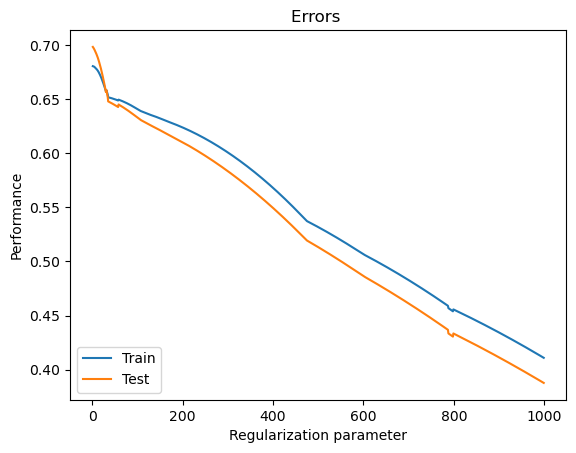

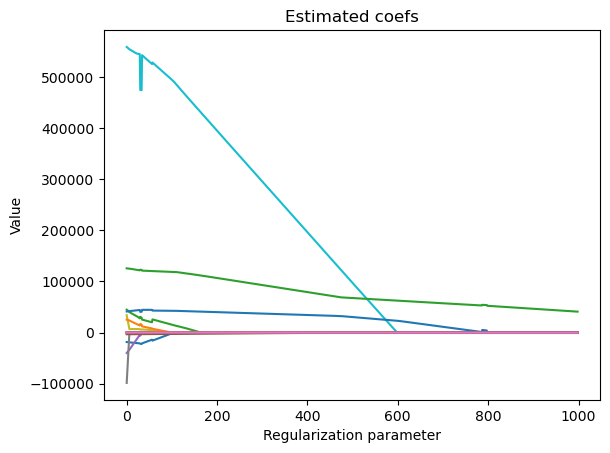

In [21]:
X_train, X_test, y_train, y_test = train_test_split(sales[all_features], sales['price'], test_size=0.2, random_state=1)

train_scores = []
test_scores = []
w_list = []
alphas = np.arange(1,1000,1)
for alpha in alphas:
    clf = linear_model.Lasso(alpha  = alpha, normalize=True)
    scores = cross_validate(clf, X_train, y_train, cv=5,return_estimator = True) 
    # print(scores['test_score'])
    estymator  = scores['estimator'][np.argmax(scores['test_score'])]
    train_score = estymator.score(X_train,y_train)
    test_score = estymator.score(X_test,y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    w = estymator.coef_
    w_list.append(w)


plt.title('Errors ')
plt.plot(alphas, train_scores, label="Train")
plt.plot(alphas, test_scores, label="Test")

plt.legend(loc="lower left")
# plt.ylim([0, 1.2])

plt.ylabel("Performance")
plt.xlabel("Regularization parameter")
# # Show estimated coef_ vs true coef
plt.show()
# plt.plot(coef, label="True coef")
plt.title("Estimated coefs")
plt.plot(w_list)
plt.ylabel("Value")
plt.xlabel("Regularization parameter")

# plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()

In [22]:
# Miejsce na kod

# okreslenie najlepszej lampdy 

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

X_train, X_test, y_train, y_test = train_test_split(sales[all_features], sales['price'], test_size=0.2, random_state=1)

reg = LassoCV(cv=5, random_state=1,alphas = np.arange(1,1000,10),normalize=True).fit(X_train, y_train)

print('Najlepsza lampda ',reg.alpha_) 
print('Wspólczyniki modelu ',reg.coef_)
# print(reg.alphas)

rms = mean_squared_error(y_test, np.dot(X_test ,(reg.coef_).reshape(len(reg.coef_),1))  , squared=False) / len(y_test)
rms


Najlepsza lampda  11
Wspólczyniki modelu  [-1.99645724e+04  2.61591097e+02  3.96327570e+04  4.37552758e+02
 -2.71918147e+04  3.59020814e-01 -4.46993235e+02 -0.00000000e+00
  6.63058408e+03  5.18332204e+05  4.15548010e+04  2.33733695e+04
  1.25153345e+05  0.00000000e+00  7.66993789e-01 -3.14332837e+03
  1.55717486e+01]


1387.5894776018954

**Pytania:**
1. Jaką wartość parametru $\lambda$ wybrałbyś/wybrałabyś dla naszego modelu ?
2. Które z cech, dla ustalonej wartości parametru $\lambda$ wchodzą w skład modelu - podaj w kolejności od najbardziej znaczących cech ?

In [23]:
# 1. Jaką wartość parametru $\lambda$ wybrałbyś/wybrałabyś dla naszego modelu ?
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

X_train, X_test, y_train, y_test = train_test_split(sales[all_features], sales['price'], test_size=0.2, random_state=1)

reg = LassoCV(cv=5, random_state=1,alphas = np.arange(1,100,1),normalize=True).fit(X_train, y_train)

print('Najlepsza lampda ',reg.alpha_) 
# print('Wspólczyniki modelu ',reg.coef_)

features_dict = dict()
for index_column,value in enumerate(reg.coef_ ): # gdzie współczynik nie są rowne zero 
    if value != 0:
        features_dict[value] = all_features[index_column]

dictionary_items = features_dict.items()
print('Najwazniejsze cechy')
for feature in reversed(sorted(dictionary_items)):
    print(feature)

# dictionary_items
# sorted(dictionary_items)

Najlepsza lampda  10
Najwazniejsze cechy
(519034.4572598524, 'waterfront')
(125364.7901063639, 'grade')
(41410.696881026495, 'view')
(40123.10346975429, 'bathrooms')
(23837.7978599034, 'condition')
(6661.45814464587, 'floors_square')
(451.29512218786164, 'sqft_living')
(283.69695092136794, 'bedrooms_square')
(15.998482807334511, 'yr_renovated')
(1.1260603496435573, 'sqft_basement')
(0.38719642660026665, 'sqft_lot')
(-465.6532647007787, 'sqft_lot_sqrt')
(-3140.5349401195554, 'yr_built')
(-19875.231322144617, 'bedrooms')
(-28559.47512789498, 'sqft_living_sqrt')


-Trzeba zauwazyć, że ujemne współczyniki  mogą wynikac z faktu, że dana cecha jest zwiazana z dwoma atrybutami  w zbiorze ( np. bedrooms oraz  bedrooms_square ). 

-Współczynik yr_built jest ujemny, a to dlatego, że im młodszy budynek, to rok jest wiekszy. 

- Atrybuty (1.1260603496435573, 'sqft_basement') oraz (0.38719642660026665, 'sqft_lot') mają małe znaczenie wiec można je pominać.
 
- Do okreslenia ważności współczynika, lepiej jest wziać wartośc bezwgledną współczynika

